In [2]:
# Main Calculation Flow of Vector Autoregression (VAR) Model
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# -----------------------------
# 1. Load & Prepare Data
# -----------------------------
# Example: Simulated time series data for two variables (Y1, Y2)
np.random.seed(42)
n_obs = 100
time_index = pd.date_range(start='2000-01-01', periods=n_obs, freq='ME')

data = pd.DataFrame({
    'Y1': np.cumsum(np.random.randn(n_obs)),  # Random walk
    'Y2': np.cumsum(np.random.randn(n_obs))   # Random walk
}, index=time_index)

# -----------------------------
# 2. Hypothesis Testing: Check Stationarity
# -----------------------------
def check_stationarity(series, alpha=0.05):
    """Perform Augmented Dickey-Fuller Test for stationarity."""
    result = adfuller(series)
    p_value = result[1]
    return "Stationary" if p_value < alpha else "Non-Stationary"

stationarity_results = {col: check_stationarity(data[col]) for col in data.columns}
print("📌 Stationarity Check Results:", stationarity_results)

# -----------------------------
# 3. Fit VAR Model Using OLS
# -----------------------------
var_model = VAR(data)
selected_lag = var_model.select_order(maxlags=10)  # Auto-select lag based on AIC
lag_order = selected_lag.aic  # Use AIC for optimal lag selection
print(f"📌 Selected Lag Order: {lag_order}")

var_results = var_model.fit(lag_order)

# -----------------------------
# 4. Display Parameter Estimates
# -----------------------------
print("\n📌 VAR Model Coefficients:")
print(var_results.params)  # Print estimated coefficients

print("\n📌 VAR Model Standard Errors:")
print(var_results.bse)  # Print standard errors

# Store fitted model for use in derivative flows
fitted_VAR = var_results

📌 Stationarity Check Results: {'Y1': 'Non-Stationary', 'Y2': 'Non-Stationary'}
📌 Selected Lag Order: 1

📌 VAR Model Coefficients:
             Y1        Y2
const -0.284412  0.062006
L1.Y1  0.970888 -0.006850
L1.Y2 -0.011445  0.927118

📌 VAR Model Standard Errors:
             Y1        Y2
const  0.156353  0.161205
L1.Y1  0.021261  0.021921
L1.Y2  0.037752  0.038924


In [3]:
# Flow 1: Parameter Estimation
import numpy as np
import pandas as pd

# -----------------------------
# 1. Parameter Estimates
# -----------------------------
coefficients = fitted_VAR.params  # Estimated coefficients

# -----------------------------
# 2. Compute Standard Errors, t-Statistics, and p-Values
# -----------------------------
std_errors = fitted_VAR.bse   # Standard errors
t_statistics = fitted_VAR.tvalues  # t-statistics
p_values = fitted_VAR.pvalues  # p-values

# -----------------------------
# 3. Print Results & Decision
# -----------------------------
print("\n📌 VAR Model Parameter Estimation (Flow 1):")
print("✅ Estimated Coefficients:\n", coefficients)
print("\n✅ Standard Errors:\n", std_errors)
print("\n✅ t-Statistics:\n", t_statistics)
print("\n✅ p-Values:\n", p_values)

# Decision: Check if coefficients are statistically significant
alpha = 0.05
significant_params = (p_values < alpha)
print("\n📌 Decision: Significant Coefficients at α = 0.05\n", significant_params)


📌 VAR Model Parameter Estimation (Flow 1):
✅ Estimated Coefficients:
              Y1        Y2
const -0.284412  0.062006
L1.Y1  0.970888 -0.006850
L1.Y2 -0.011445  0.927118

✅ Standard Errors:
              Y1        Y2
const  0.156353  0.161205
L1.Y1  0.021261  0.021921
L1.Y2  0.037752  0.038924

✅ t-Statistics:
               Y1         Y2
const  -1.819036   0.384640
L1.Y1  45.665488  -0.312513
L1.Y2  -0.303152  23.818746

✅ p-Values:
              Y1             Y2
const  0.068906   7.005043e-01
L1.Y1  0.000000   7.546508e-01
L1.Y2  0.761774  2.135687e-125

📌 Decision: Significant Coefficients at α = 0.05
           Y1     Y2
const  False  False
L1.Y1   True  False
L1.Y2  False   True


In [ ]:
# Flow 2: Model Diagnostics
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm

# Significance Level
alpha = 0.05
z_critical = norm.ppf(1 - alpha / 2)  # 95% confidence interval

# -----------------------------
# 1. Compute Autocorrelation Function (ACF)
# -----------------------------
residuals = fitted_VAR.resid.dropna()  # Extract residuals from the VAR model
acf_values = {col: acf(residuals[col], nlags=10) for col in residuals.columns}

# -----------------------------
# 2. Perform Ljung-Box Test (Serial Correlation in Residuals)
# -----------------------------
ljung_p_values = {
    col: acorr_ljungbox(residuals[col], lags=[10], return_df=True)['lb_pvalue'].values[0]
    for col in residuals.columns
}

# -----------------------------
# 3. Perform Augmented Dickey-Fuller (ADF) Test (Stationarity)
# -----------------------------
adf_p_values = {
    col: adfuller(residuals[col])[1]  # Extract p-value
    for col in residuals.columns
}

# -----------------------------
# 4. Compute Standard Errors & Confidence Intervals
# -----------------------------
std_errors = fitted_VAR.bse  # Standard errors (DataFrame)
params = fitted_VAR.params   # Estimated coefficients (DataFrame)

# Compute confidence intervals correctly (column-wise)
lower_bounds = params.sub(z_critical * std_errors)  # Element-wise subtraction
upper_bounds = params.add(z_critical * std_errors)  # Element-wise addition

confidence_intervals = pd.concat([lower_bounds, upper_bounds], axis=1, keys=["Lower Bound", "Upper Bound"])

# -----------------------------
# 5. Print Results & Decision
# -----------------------------
print("\n📌 VAR Model Diagnostics (Flow 2):")

print("\n✅ Autocorrelation Function (ACF):")
for col, acf_val in acf_values.items():
    print(f"\n🔹 ACF for {col}:\n", acf_val)

print("\n✅ Ljung-Box Test (p-values):", ljung_p_values)

print("\n✅ Augmented Dickey-Fuller (ADF) Test (p-values):", adf_p_values)

print("\n✅ Standard Errors:\n", std_errors)

print("\n✅ 95% Confidence Intervals:\n", confidence_intervals)

# Decision: Check if residuals are white noise (Ljung-Box) & stationary (ADF)
ljung_decision = {col: p > alpha for col, p in ljung_p_values.items()}
adf_decision = {col: p < alpha for col, p in adf_p_values.items()}

print("\n📌 Decision:")
print("➡️ Ljung-Box Test (White Noise in Residuals):", ljung_decision)
print("➡️ Augmented Dickey-Fuller Test (Stationary Residuals):", adf_decision)


📌 VAR Model Diagnostics (Flow 2):

✅ Autocorrelation Function (ACF):

🔹 ACF for Y1:
 [ 1.         -0.01216666 -0.03940952 -0.03260222 -0.05133292  0.19543724
 -0.04141325 -0.01771791 -0.13238157 -0.01643969 -0.10143338]

🔹 ACF for Y2:
 [ 1.         -0.06523632 -0.02481182  0.0295414  -0.16656138  0.02961009
  0.15415139  0.09336588 -0.01484509 -0.07768249 -0.02881792]

✅ Ljung-Box Test (p-values): {'Y1': np.float64(0.6331049344775049), 'Y2': np.float64(0.6393774585668863)}

✅ Augmented Dickey-Fuller (ADF) Test (p-values): {'Y1': np.float64(3.069305543480281e-17), 'Y2': np.float64(1.6798566607568435e-18)}

✅ Standard Errors:
              Y1        Y2
const  0.156353  0.161205
L1.Y1  0.021261  0.021921
L1.Y2  0.037752  0.038924

✅ 95% Confidence Intervals:
       Lower Bound           Upper Bound          
               Y1        Y2          Y1        Y2
const   -0.590858 -0.253950    0.022034  0.377961
L1.Y1    0.929217 -0.049814    1.012558  0.036113
L1.Y2   -0.085438  0.850829    0

In [ ]:
# Flow 3: Forecasting Future Values
import numpy as np
import pandas as pd
from scipy.stats import norm

# Significance Level
alpha = 0.05
z_critical = norm.ppf(1 - alpha / 2)  # 95% Confidence Interval

# -----------------------------
# 1. One-Step Ahead Forecasting
# -----------------------------
one_step_forecast = fitted_VAR.forecast(y=fitted_VAR.endog[-fitted_VAR.k_ar:], steps=1)
one_step_forecast_df = pd.DataFrame(one_step_forecast, columns=fitted_VAR.names)

# -----------------------------
# 2. Multi-Step Ahead Forecasting
# -----------------------------
forecast_horizon = 5  # Predict next 5 time steps
multi_step_forecast = fitted_VAR.forecast(y=fitted_VAR.endog[-fitted_VAR.k_ar:], steps=forecast_horizon)
multi_step_forecast_df = pd.DataFrame(multi_step_forecast, columns=fitted_VAR.names)

# -----------------------------
# 3. Compute Prediction Intervals
# -----------------------------
# Get forecast covariance matrix (NO `y` ARGUMENT!)
forecast_cov = fitted_VAR.forecast_cov(steps=forecast_horizon)

# Compute standard errors for each forecasted step
forecast_std_errors = np.sqrt(np.array([np.diag(cov) for cov in forecast_cov]))

# Compute confidence intervals
lower_bounds = multi_step_forecast_df - z_critical * forecast_std_errors
upper_bounds = multi_step_forecast_df + z_critical * forecast_std_errors

prediction_intervals = pd.concat([lower_bounds, upper_bounds], axis=1, keys=["Lower Bound", "Upper Bound"])

# -----------------------------
# 4. Forecast Errors & Confidence Interval
# -----------------------------
# Compute forecast errors (Actual - Forecasted)
actual_values = fitted_VAR.endog[-forecast_horizon:]  # Last observed values
forecast_errors = actual_values - multi_step_forecast_df.iloc[:forecast_horizon].values

# Compute confidence intervals for forecast errors
forecast_error_std = forecast_errors.std(axis=0)
error_lower_bounds = forecast_errors.mean(axis=0) - z_critical * forecast_error_std
error_upper_bounds = forecast_errors.mean(axis=0) + z_critical * forecast_error_std

forecast_error_intervals = pd.DataFrame(
    np.vstack([error_lower_bounds, error_upper_bounds]).T,
    columns=["Error Lower Bound", "Error Upper Bound"],
    index=fitted_VAR.names
)

# -----------------------------
# 5. Print Results & Decision
# -----------------------------
print("\n📌 VAR Model Forecasting (Flow 3):")

print("\n✅ One-Step Ahead Forecast:\n", one_step_forecast_df)

print("\n✅ Multi-Step Ahead Forecast:\n", multi_step_forecast_df)

print("\n✅ 95% Prediction Intervals:\n", prediction_intervals)

print("\n✅ Forecast Errors:\n", forecast_errors)

print("\n✅ Forecast Errors 95% Confidence Interval:\n", forecast_error_intervals)

# Decision: If prediction intervals are too wide, model tuning is needed.
print("\n📌 Decision:")
print("➡️ If prediction intervals are too wide, consider adjusting lag order or re-evaluating model assumptions.")


📌 VAR Model Forecasting (Flow 3):

✅ One-Step Ahead Forecast:
           Y1        Y2
0 -10.392269  2.201044

✅ Multi-Step Ahead Forecast:
           Y1        Y2
0 -10.392269  2.201044
1 -10.399327  2.173825
2 -10.405869  2.148638
3 -10.411931  2.125332
4 -10.417551  2.103765

✅ 95% Prediction Intervals:
   Lower Bound           Upper Bound          
           Y1        Y2          Y1        Y2
0  -12.178041  0.359858   -8.606497  4.042229
1  -12.890327 -0.338040   -7.908327  4.685689
2  -13.415597 -0.822009   -7.396140  5.119285
3  -13.841006 -1.190186   -6.982857  5.440849
4  -14.200950 -1.482595   -6.634152  5.690126

✅ Forecast Errors:
 [[-0.320085    1.84430888]
 [-0.01690624  0.9876704 ]
 [ 0.25069051  1.16658235]
 [ 0.26186675  1.24809742]
 [ 0.03289917  0.12669333]]

✅ Forecast Errors 95% Confidence Interval:
     Error Lower Bound  Error Upper Bound
Y1          -0.375509           0.458895
Y2          -0.012040           2.161381

📌 Decision:
➡️ If prediction intervals are 

In [ ]:
# Flow 4: Residual Analysis
import numpy as np
import pandas as pd
from statsmodels.stats.stattools import durbin_watson, jarque_bera

# -----------------------------
# 1. Compute Model Residuals
# -----------------------------
residuals = fitted_VAR.resid  # Extract residuals from fitted VAR model

# -----------------------------
# 2. Durbin-Watson Test (Check Serial Correlation)
# -----------------------------
dw_stats = durbin_watson(residuals)

# -----------------------------
# 3. Jarque-Bera Test (Check Normality)
# -----------------------------
jb_results = np.apply_along_axis(jarque_bera, 0, residuals)

# Extract test statistics and p-values correctly
jb_stat_values = jb_results[0]  # Test statistic
jb_p_values = jb_results[1]  # P-value

# -----------------------------
# 4. Print Results & Decision
# -----------------------------
print("\n📌 VAR Model Residual Analysis (Flow 4):")

# Print Durbin-Watson Test Results
dw_results = pd.DataFrame(dw_stats, index=fitted_VAR.names, columns=["Durbin-Watson"])
print("\n✅ Durbin-Watson Test (Check Serial Correlation):\n", dw_results)

# Print Jarque-Bera Test Results
jb_results_df = pd.DataFrame(
    {"JB Statistic": jb_stat_values, "p-value": jb_p_values},
    index=fitted_VAR.names,
)
print("\n✅ Jarque-Bera Test (Check Normality):\n", jb_results_df)

# -----------------------------
# 5. Decision Making
# -----------------------------
print("\n📌 Decision:")
print("➡️ If Durbin-Watson is close to 2, residuals show no strong autocorrelation.")
print("➡️ If Jarque-Bera p-value < 0.05, residuals deviate from normality.")


📌 VAR Model Residual Analysis (Flow 4):

✅ Durbin-Watson Test (Check Serial Correlation):
     Durbin-Watson
Y1       2.023534
Y2       2.113979

✅ Jarque-Bera Test (Check Normality):
     JB Statistic   p-value
Y1      0.296789  0.862091
Y2      2.890152  0.235728

📌 Decision:
➡️ If Durbin-Watson is close to 2, residuals show no strong autocorrelation.
➡️ If Jarque-Bera p-value < 0.05, residuals deviate from normality.


In [16]:
# Flow 5: Stability Analysis
import numpy as np
import pandas as pd

# -----------------------------
# 1. Compute Characteristic Roots (Check Stability Condition)
# -----------------------------
eigvals = np.linalg.eigvals(fitted_VAR.coefs.sum(axis=0))  # Eigenvalues of coefficient matrix
inside_unit_circle = np.all(np.abs(eigvals) < 1)  # Stability check

# -----------------------------
# 2. Compute Mean Reversion Time
# -----------------------------
mean_reversion_time = -1 / np.log(np.abs(eigvals))  # Time to return to equilibrium

# -----------------------------
# 3. Print Results & Decision
# -----------------------------
print("\n📌 VAR Model Stability Analysis (Flow 5):")

# Print Characteristic Roots
eigvals_df = pd.DataFrame(
    {"Eigenvalues": eigvals, "Inside Unit Circle": np.abs(eigvals) < 1}
)
print("\n✅ Characteristic Roots (Check Stability Condition):\n", eigvals_df)

# Print Mean Reversion Time
mean_reversion_df = pd.DataFrame(
    {"Mean Reversion Time": mean_reversion_time},
    index=[f"Root {i+1}" for i in range(len(eigvals))],
)
print("\n✅ Mean Reversion Time (Assess Speed of Return to Equilibrium):\n", mean_reversion_df)

# -----------------------------
# 4. Decision Making
# -----------------------------
print("\n📌 Decision:")
if inside_unit_circle:
    print("✅ The VAR model is **stable** (All characteristic roots lie inside the unit circle).")
else:
    print("❌ The VAR model is **unstable** (Some characteristic roots lie outside the unit circle).")
print("➡️ Higher mean reversion time means slower return to equilibrium.")


📌 VAR Model Stability Analysis (Flow 5):

✅ Characteristic Roots (Check Stability Condition):
    Eigenvalues  Inside Unit Circle
0     0.972611                True
1     0.925395                True

✅ Mean Reversion Time (Assess Speed of Return to Equilibrium):
         Mean Reversion Time
Root 1            36.008717
Root 2            12.897391

📌 Decision:
✅ The VAR model is **stable** (All characteristic roots lie inside the unit circle).
➡️ Higher mean reversion time means slower return to equilibrium.


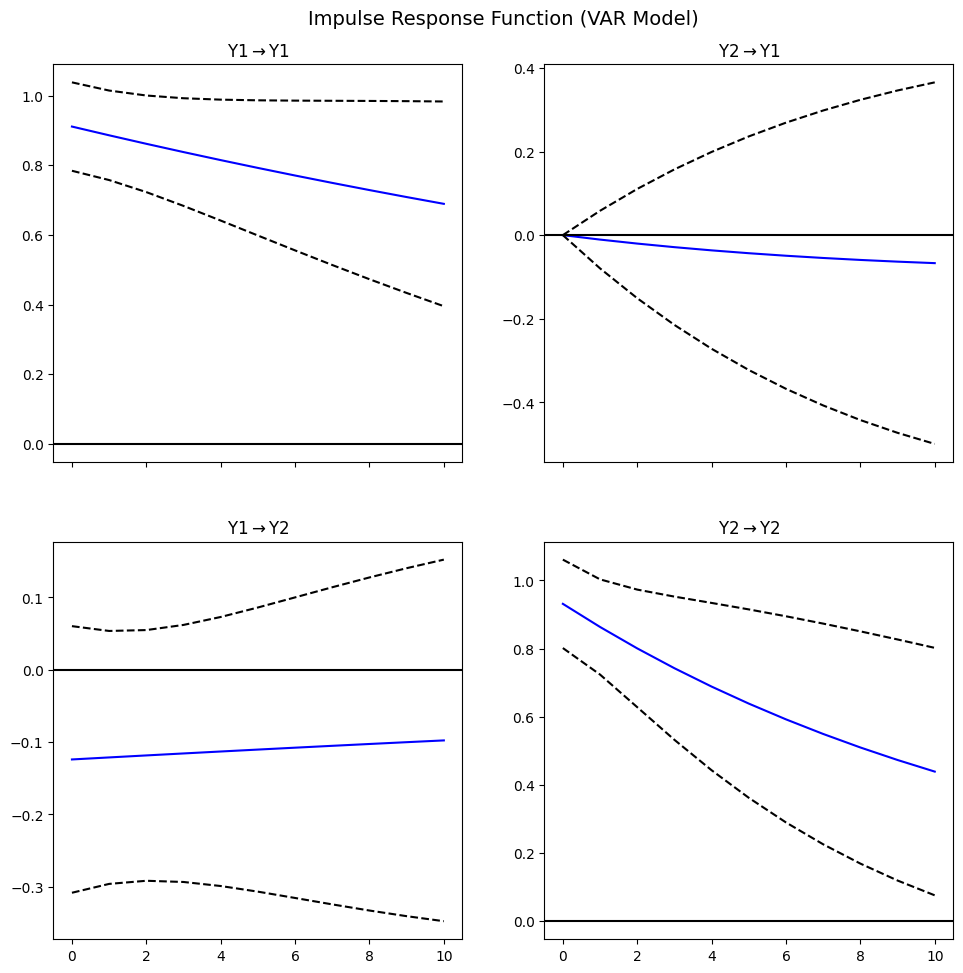


📌 Impulse Response Function (Numerical Representation):

✅ Response of Y1:
           Y1        Y2
1   1.000000  0.000000
2   0.970888 -0.006850
3   0.942701 -0.013002
4   0.915406 -0.018513
5   0.888968 -0.023434
6   0.863356 -0.027816
7   0.838540 -0.031703
8   0.814491 -0.035137
9   0.791182 -0.038156
10  0.768585 -0.040795
11  0.746677 -0.043087

✅ Response of Y2:
           Y1        Y2
1   0.000000  1.000000
2  -0.011445  0.927118
3  -0.021722  0.859626
4  -0.030928  0.797124
5  -0.039150  0.739239
6  -0.046471  0.685630
7  -0.052965  0.635979
8  -0.058702  0.589990
9  -0.063745  0.547392
10 -0.068154  0.507934
11 -0.071983  0.471382

📌 Decision:
➡️ The Impulse Response Function (IRF) shows how each variable reacts to a shock in another variable.
➡️ A prolonged impact indicates a **strong, persistent effect**, while a quick return to zero indicates a **short-lived response**.
✅ **Visualize the IRF plots** to analyze variable interactions over time.


In [17]:
# Flow 6: Impulse Response Function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Compute Impulse Response Function (IRF)
# -----------------------------
irf = fitted_VAR.irf(10)  # Compute IRF for 10 time periods

# -----------------------------
# 2. Plot Impulse Response Functions
# -----------------------------
fig = irf.plot(orth=True)  # Orthogonalized IRF for clearer interpretation
plt.suptitle("Impulse Response Function (VAR Model)", fontsize=14)
plt.show()

# -----------------------------
# 3. Print Results (Numerical Representation)
# -----------------------------
irf_values = irf.irfs  # Extract IRF values

# Convert to DataFrame for better readability
irf_df = {
    f"Response of {var}": pd.DataFrame(irf_values[:, :, idx], 
                                       columns=fitted_VAR.model.endog_names, 
                                       index=range(1, irf_values.shape[0] + 1))
    for idx, var in enumerate(fitted_VAR.model.endog_names)
}

# Print IRF Values
print("\n📌 Impulse Response Function (Numerical Representation):")
for response, df in irf_df.items():
    print(f"\n✅ {response}:\n", df)

# -----------------------------
# 4. Decision Making
# -----------------------------
print("\n📌 Decision:")
print("➡️ The Impulse Response Function (IRF) shows how each variable reacts to a shock in another variable.")
print("➡️ A prolonged impact indicates a **strong, persistent effect**, while a quick return to zero indicates a **short-lived response**.")
print("✅ **Visualize the IRF plots** to analyze variable interactions over time.")

In [18]:
# Flow 7: Information Criteria
import pandas as pd

# -----------------------------
# 1. Extract Information Criteria
# -----------------------------
aic = fitted_VAR.aic  # Akaike Information Criterion
bic = fitted_VAR.bic  # Bayesian Information Criterion
hqc = fitted_VAR.hqic # Hannan-Quinn Information Criterion

# Store criteria in a DataFrame
info_criteria_df = pd.DataFrame({
    "AIC (Akaike)": [aic],
    "BIC (Bayesian)": [bic],
    "HQC (Hannan-Quinn)": [hqc]
})

# -----------------------------
# 2. Print Results
# -----------------------------
print("\n📌 Information Criteria (VAR Model):")
print(info_criteria_df)

# -----------------------------
# 3. Decision Making
# -----------------------------
print("\n📌 Decision:")
print("➡️ **Lower values** indicate a better model fit.")
print("➡️ **AIC**: Balances goodness of fit and model complexity.")
print("➡️ **BIC**: More strict, penalizing complex models more.")
print("➡️ **HQC**: A middle-ground between AIC and BIC.")
print("✅ **Choose the lag order that minimizes these values.**")


📌 Information Criteria (VAR Model):
   AIC (Akaike)  BIC (Bayesian)  HQC (Hannan-Quinn)
0     -0.269103       -0.111823           -0.205468

📌 Decision:
➡️ **Lower values** indicate a better model fit.
➡️ **AIC**: Balances goodness of fit and model complexity.
➡️ **BIC**: More strict, penalizing complex models more.
➡️ **HQC**: A middle-ground between AIC and BIC.
✅ **Choose the lag order that minimizes these values.**


In [24]:
import numpy as np
import pandas as pd
import warnings
import os
import sys
from statsmodels.tsa.stattools import grangercausalitytests

# -----------------------------
# 1. Generate Random Data
# -----------------------------
np.random.seed(42)  # For reproducibility
num_obs = 100  # Number of observations

# Create random time series data
data = pd.DataFrame(
    np.random.randn(num_obs, 3),  # 3 random variables
    columns=["Variable_1", "Variable_2", "Target_Variable"],
)

# -----------------------------
# 2. Perform Granger Causality Test
# -----------------------------
max_lag = 5  # Maximum lags for testing
target_variable = "Target_Variable"

print("\n📌 Granger Causality Test Results:")
granger_results = {}

for col in data.columns:
    if col != target_variable:  # Exclude self-testing
        print(f"\n➡️ Testing if {col} Granger-causes {target_variable} (H0: No causality)")

        # Suppress verbose output correctly for Windows
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)

            # Redirect stdout to suppress printed output
            original_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')  # Use os.devnull for Windows compatibility
            test_result = grangercausalitytests(data[[target_variable, col]], max_lag, verbose=False)
            sys.stdout.close()  # Close the stream properly
            sys.stdout = original_stdout  # Restore stdout

        # Extract p-values for decision making
        p_values = [test_result[i][0]['ssr_chi2test'][1] for i in range(1, max_lag + 1)]
        granger_results[col] = p_values

# -----------------------------
# 3. Print Results & Decision
# -----------------------------
print("\n📌 Decision (p-values per lag):")
for variable, p_vals in granger_results.items():
    decision = ["Reject H₀ (Causality)" if p < 0.05 else "Fail to Reject H₀ (No Causality)" for p in p_vals]
    results_df = pd.DataFrame({"Lag": list(range(1, max_lag + 1)), "p-value": p_vals, "Decision": decision})
    print(f"\n➡️ {variable} Granger-causing {target_variable}:")
    print(results_df)


📌 Granger Causality Test Results:

➡️ Testing if Variable_1 Granger-causes Target_Variable (H0: No causality)

➡️ Testing if Variable_2 Granger-causes Target_Variable (H0: No causality)

📌 Decision (p-values per lag):

➡️ Variable_1 Granger-causing Target_Variable:
   Lag   p-value                          Decision
0    1  0.921930  Fail to Reject H₀ (No Causality)
1    2  0.810441  Fail to Reject H₀ (No Causality)
2    3  0.932791  Fail to Reject H₀ (No Causality)
3    4  0.716386  Fail to Reject H₀ (No Causality)
4    5  0.684258  Fail to Reject H₀ (No Causality)

➡️ Variable_2 Granger-causing Target_Variable:
   Lag   p-value                          Decision
0    1  0.061026  Fail to Reject H₀ (No Causality)
1    2  0.121676  Fail to Reject H₀ (No Causality)
2    3  0.133621  Fail to Reject H₀ (No Causality)
3    4  0.222113  Fail to Reject H₀ (No Causality)
4    5  0.328384  Fail to Reject H₀ (No Causality)
